In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)


Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [4]:
from IPython.display import Image
Image(filename='/home/shreenath/personal-projects/mooc/ud730-deeplearning/notMNIST_small/B/RWNrbWFubkQudHRm.png') 

In [5]:
# We now want to convert the entire dataset into a 3D array
# (image index, x, y), with mean = 0  and s.d. = 0.5
img_wd = 28 #it is known
img_ht = 28 #it is known

def load_letter(folderpath, min_num_images):
    '''Loading for a single character'''
    img_files = os.listdir(folderpath)
    tot_imgs = len(img_files)
    dataset = np.ndarray(shape = (tot_imgs, img_wd, img_ht),
                         dtype = np.float32)
    img_index = 0
    for img in img_files:
        img_file_path = os.path.join(folderpath, img)
        try:
            img_data = (ndimage.imread(img_file_path).astype(float) - 255.0/2)/255.0
            # We did the above to set the range of the image data to 
            # -0.5 to 0.5 (s.d.)
            if img_data.shape != (img_wd, img_ht):
                raise Exception('incorrect image shape')
            dataset[img_index, :, :] = img_data
            img_index = img_index + 1
        except IOError as e:
            print('file read error, skipping thsi file')
    
    if img_index<min_num_images:
        raise Exception('fewer images thanr reqd.')
                
    print('Full dataset shape', dataset.shape)
    print('Dataset Mean', np.mean(dataset))
    print('Dataset SD', np.std(dataset))
    return dataset
        

In [6]:
print(train_folders)

['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']


In [7]:
# Below, we intend to store the read images into pickle dump
# in the data folders_.pickle files
def pickling(image_folders, min_num_images, force = False):
    dataset_pickle_filenames=[]
    for folder in image_folders:
        set_filename = folder + '.pickle'
        dataset_pickle_filenames.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print("already exists the pickle file")
        else:
            print('pickling %s file' % set_filename)
            dataset = load_letter(folder, min_num_images)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
                    # just like that <--protocol
            except Exception as e:
                print('unable to save data to %s' % set_filename)
    return dataset_pickle_filenames
    # We returned the dataset file names where our normalised 
    # files are stored.

In [8]:
#print(train_folders)
#print(test_folders)
train_datasets = pickling(train_folders, 45000)
test_datasets = pickling(test_folders, 1800)
print(train_datasets)
print(test_datasets)

already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
already exists the pickle file
['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle', './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']
['./notMNIST_small/A.pickle', './notMNIST_small/B.pickle', './notMNIST_small/C.pickle', '

In [9]:
with open(test_datasets[0],'r') as td1:
    dataset1 = pickle.load(td1)
    print(dataset1.size)

1468432


(28, 28)


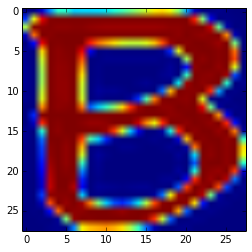

In [22]:
# Verifying that images are still the same
import matplotlib.pyplot as plt
with open('./notMNIST_small/B.pickle') as file:
    img = pickle.load(file)
    print(img[0].shape)
    plt.imshow(img[2])

1873
1873
1873
1873
1873
1873
1872
1872
1872
1872


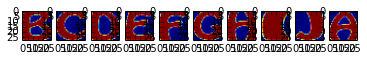

In [35]:
# Now verifying that data is balanced across all the classes
fig=plt.figure()
i=0
for ds in test_datasets:
    with open(ds) as file:
        obj = pickle.load(file)
        print(obj.shape[0])
        fig.add_subplot(1,10,i)
        plt.imshow(obj[0])
        i=i+1
plt.show()

In [36]:
def make_arrays(tot_rows, imwidth, imheight):
    if tot_rows!=0:
        dataset = np.ndarray((tot_rows, imwidth, imheight), dtype=np.float32)
        labels = np.ndarray(tot_rows, dtype=np.int32)
    else:
        dataset = None
        labels = None
    return dataset, labels
        

In [48]:
def merge_datasets(pickle_files, train_size, validn_size=0):
    num_classes = len(pickle_files)
    validn_dataset, validn_labels = make_arrays(validn_size,img_wd, img_ht)
    train_dataset, train_labels = make_arrays(train_size,img_wd, img_ht)
    # // operator does an int division : its like floor, but with integers
    vsize_per_class = validn_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    
    for label, pfile in enumerate(pickle_files):
        # this adds an index 0,1,2.. to the pickle files as well
        try:
            with open(pfile, 'rb') as file:
                data = pickle.load(file)
                print('loaded data shape :',data.shape)
                np.random.shuffle(data)
                if validn_dataset is not None:
                    validn_data = data[:vsize_per_class, :, :]
                    validn_dataset[start_v:end_v, :, :] = validn_data
                    validn_labels [start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                
                # we are basically doing 
                # validn = 0 to 20
                # test = 20 to 70, etc.
                train_data = data[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_data
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('unable ot process data from ', pfile)
            raise
    return validn_dataset, validn_labels, train_dataset, train_labels


train_size = 20000
validn_size = 10000
test_size = 1000

print('generating training data')
validn_dataset, validn_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, validn_size)
print('generating test data')
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)
# in above, we put validn size as default, so that validation set is not generated

print('training:', train_dataset.shape, train_labels.shape)
print('validn:', validn_dataset.shape, validn_labels.shape)
print('test:', test_dataset.shape, test_labels.shape)


    

generating training data
loaded data shape : (52912, 28, 28)
loaded data shape : (52912, 28, 28)
loaded data shape : (52912, 28, 28)
loaded data shape : (52912, 28, 28)
loaded data shape : (52912, 28, 28)
loaded data shape : (52912, 28, 28)
loaded data shape : (52912, 28, 28)
loaded data shape : (52912, 28, 28)
loaded data shape : (52912, 28, 28)
loaded data shape : (52911, 28, 28)
generating test data
loaded data shape : (1873, 28, 28)
loaded data shape : (1873, 28, 28)
loaded data shape : (1873, 28, 28)
loaded data shape : (1873, 28, 28)
loaded data shape : (1873, 28, 28)
loaded data shape : (1873, 28, 28)
loaded data shape : (1872, 28, 28)
loaded data shape : (1872, 28, 28)
loaded data shape : (1872, 28, 28)
loaded data shape : (1872, 28, 28)
training: (20000, 28, 28) (20000,)
validn: (10000, 28, 28) (10000,)
test: (1000, 28, 28) (1000,)


In [49]:
#noe randomizing the data
def randomize(dataset, labels):
    # we will use permutation function to generate a random ordering of all the items
    perm = np.random.permutation(labels.shape[0]) # sicne all have sam enumber of rows
    shuffled_dataset = dataset[perm, :,:]
    shuffled_labels = labels[perm]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
validn_dataset, validn_labels = randomize(validn_dataset, validn_labels)

In [55]:
# convincing that data is randomized
# we can just check with labels, since they are one 2 one mapped
# checking that images are the same will take some effrt. hence not doing it
for i in range(10):
    print(train_labels[i], test_labels[i],validn_labels[i])

7 3 6
0 3 7
4 8 2
9 6 0
0 9 1
2 5 4
3 1 5
5 1 3
5 4 2
8 7 0


In [56]:
#Saving the dataset now for processing

full_pickle_file = os.path.join(data_root, 'notMNIST.pickle') # storing at "."
try:
    f=open(full_pickle_file, 'wb')
    full_data = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        'validn_dataset': validn_dataset,
        'validn_labels' : validn_labels,
    }
    pickle.dump(full_data, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print("Error occured in pickle dumping to ", full_pickle_file)
    
statinfo = os.stat(full_pickle_file)
print("compressed pickle file size:", statinfo.st_size)

compressed pickle file size: 97340439


In [ ]:
# TODO: train a liner model on this data

In [33]:
data_root = '.'
created_pickle_file = os.path.join(data_root, 'notMNIST.pickle')
with open(created_pickle_file, 'rb') as f:
    read_data = pickle.load(f)
#     for k in read_data:
#         print(k)

train_ds = read_data['train_dataset']
train_lbls = read_data['train_labels']

test_ds = read_data['test_dataset']
test_lbls = read_data['test_labels']

from sklearn.linear_model import LogisticRegression
import numpy as np

model = LogisticRegression()

num, h, w = train_ds.shape
flatten_train_ds = np.zeros((num, h*w))

for i in range(num):
    flatten_train_ds[i,:] = train_ds[i,:,:].reshape(-1)

model.fit(flatten_train_ds, train_lbls)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
ds = read_data['validn_dataset']
lbls = read_data['validn_labels']



num, h, w = ds.shape
flatten_ds = np.zeros((num, h*w))

for i in range(num):
    flatten_ds[i,:] = ds[i,:,:].reshape(-1)

pred = model.predict(flatten_ds)


from sklearn.metrics import accuracy_score

print(accuracy_score(pred, lbls))

0.8046
